In [6]:
#IMPORTS
import warnings
import pandas as pd
import h5py
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import numpy as np
import sys
import os
import scipy.signal as sgn
import matplotlib.pyplot as plt
import random
from sklearn.manifold import TSNE
# Aplicação do HDBSCAN
import umap
from sklearn.metrics import silhouette_score
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.cluster import HDBSCAN
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, Conv1DTranspose, BatchNormalization, ELU, Input
from tensorflow.keras.models import Model

sys.path.append('../Pre-processing')  
from filters import ecg_filtrado

In [7]:
#CARREGAR OS DADOS
caminho_arquivo = "../Database/exams.csv"
dados = pd.read_csv(caminho_arquivo)
arquivos_usados = ["exams_part14.hdf5", "exams_part15.hdf5", "exams_part16.hdf5", "exams_part17.hdf5",
                   "exams_part13.hdf5", "exams_part12.hdf5", "exams_part11.hdf5", "exams_part10.hdf5",
                   "exams_part9.hdf5", "exams_part8.hdf5", "exams_part7.hdf5", "exams_part6.hdf5",
                   "exams_part5.hdf5", "exams_part4.hdf5", "exams_part3.hdf5", "exams_part2.hdf5"]

ecg_normal_linhas = dados.index[(dados.iloc[:, 14].isin(arquivos_usados))  & 
                                (dados.iloc[:, 13] == True) ]

ecg_doente_linhas = dados.index[(dados.iloc[:, 14].isin(arquivos_usados)) & 
                                (dados.iloc[:, 4] == True) & 
                                (dados.iloc[:, 5] == False ) & 
                                (dados.iloc[:, 6] == False) & 
                                (dados.iloc[:, 7] == False) & 
                                (dados.iloc[:, 8] == False) & 
                                (dados.iloc[:, 9] == False)]

print("Número de linhas ecg_normal_linhas:", len(ecg_normal_linhas))
print("Número de linhas ecg_doente_linhas:", len(ecg_doente_linhas))

caminho_interferencias = "../Database/resultados_interferencia.csv"
interferencias = pd.read_csv(caminho_interferencias)
interferencias_ids = interferencias['exam_id'].tolist()

ecg_normal_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &
                                (dados.iloc[:, 14].isin(arquivos_usados))  & 
                                (dados.iloc[:, 13] == True) ]

ecg_doente_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &
                                (dados.iloc[:, 14].isin(arquivos_usados)) & 
                                (dados.iloc[:, 4] == True) & 
                                (dados.iloc[:, 5] == False) & 
                                (dados.iloc[:, 6] == False) & 
                                (dados.iloc[:, 7] == False) & 
                                (dados.iloc[:, 8] == False) & 
                                (dados.iloc[:, 9] == False)]

print("Tirando Interferência:")
print("Número de linhas ecg_normal_linhas:", len(ecg_normal_linhas))
print("Número de linhas ecg_doente_linhas:", len(ecg_doente_linhas))

ecg_doente_id = dados.iloc[ecg_doente_linhas, 0].tolist()
ecg_normal_id = dados.iloc[ecg_normal_linhas, 0].tolist()

#ecg_doente = ecg_doente_id[]
ecg_normal = ecg_normal_id[:100]
ecg_doente = ecg_doente_id[:20]
ids_ecgs = ecg_normal + ecg_doente
print("Número de ecgs pra clusterizar:", len(ids_ecgs))

Número de linhas ecg_normal_linhas: 119367
Número de linhas ecg_doente_linhas: 3680
Tirando Interferência:
Número de linhas ecg_normal_linhas: 116040
Número de linhas ecg_doente_linhas: 3598
Número de ecgs pra clusterizar: 120


In [9]:
# Função para obter dados de ECG de um arquivo HDF5
def get_ecg_data(file_paths, exam_id):
    for file_path in file_paths:
        with h5py.File(file_path, 'r') as f:
            exam_ids = np.array(f['exam_id'])
            exam_index = np.where(exam_ids == exam_id)[0]
            if len(exam_index) != 0:
                exam_index = exam_index[0]
                exam_tracings = f['tracings'][exam_index]
                return exam_tracings
    raise ValueError("Exam ID não encontrado em nenhum dos arquivos fornecidos.")

# Caminhos para os arquivos HDF5
file_paths = ['../Database/filtered_exams_14_15.hdf5', '../Database/filtered_exams_16_17.hdf5','../Database/filtered_exams_16_17.hdf5',
              '../Database/filtered_exams_12_13.hdf5', '../Database/filtered_exams_10_11.hdf5','../Database/filtered_exams_8_9.hdf5',
              '../Database/filtered_exams_6_7.hdf5', '../Database/filtered_exams_4_5.hdf5','../Database/filtered_exams_2_3.hdf5']

# Obter os tracings de ECG para cada exam_id e armazenar na lista
all_tracings = []
for exam_id in ids_ecgs:
    tracings = get_ecg_data(file_paths, exam_id)
    # Selecionar as leads V1 (índice 6) e V6 (índice 11)
    #lead_v1 = tracings[:, 6]
    lead_d2 = tracings
    #lead_d2 = lead_d2[1024:2048]
    # Combinar as leads V1 e V6 em uma única dimensão
    #combined_leads = np.concatenate((lead_v1, lead_v6))
    all_tracings.append(lead_d2)

# Converter lista para array numpy
X = np.array(all_tracings)

print("Shape de X para o autoencoder:", X.shape)

# X agora está pronto para ser usado no autoencoder

Shape de X para o autoencoder: (120, 4096, 12)


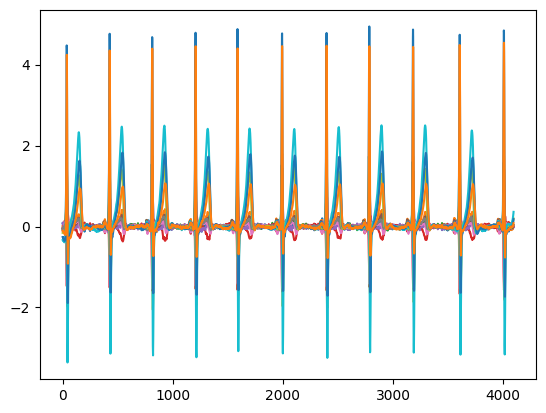

In [12]:
plt.plot(X[1])

In [17]:
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, UpSampling1D, Dropout, BatchNormalization, Activation, Add, Flatten, Dense, Reshape)
from tensorflow.keras.models import Model
import numpy as np


class ResidualUnit:
    def __init__(self, n_samples_out, n_filters_out, kernel_initializer='he_normal',
                 dropout_keep_prob=0.8, kernel_size=17, preactivation=True,
                 postactivation_bn=False, activation_function='relu'):
        self.n_samples_out = n_samples_out
        self.n_filters_out = n_filters_out
        self.kernel_initializer = kernel_initializer
        self.dropout_rate = 1 - dropout_keep_prob
        self.kernel_size = kernel_size
        self.preactivation = preactivation
        self.postactivation_bn = postactivation_bn
        self.activation_function = activation_function

    def _skip_connection(self, y, downsample, n_filters_in):
        if downsample > 1:
            y = MaxPooling1D(downsample, strides=downsample, padding='same')(y)
        elif downsample == 1:
            y = y
        else:
            raise ValueError("Number of samples should always decrease.")
        if n_filters_in != self.n_filters_out:
            y = Conv1D(self.n_filters_out, 1, padding='same',
                       use_bias=False, kernel_initializer=self.kernel_initializer)(y)
        return y

    def _batch_norm_plus_activation(self, x):
        if self.postactivation_bn:
            x = Activation(self.activation_function)(x)
            x = BatchNormalization(center=False, scale=False)(x)
        else:
            x = BatchNormalization()(x)
            x = Activation(self.activation_function)(x)
        return x

    def __call__(self, inputs):
        x, y = inputs
        n_samples_in = y.shape[1]
        downsample = n_samples_in // self.n_samples_out
        n_filters_in = y.shape[2]
        y = self._skip_connection(y, downsample, n_filters_in)
        x = Conv1D(self.n_filters_out, self.kernel_size, padding='same',
                   use_bias=False, kernel_initializer=self.kernel_initializer)(x)
        x = self._batch_norm_plus_activation(x)
        if self.dropout_rate > 0:
            x = Dropout(self.dropout_rate)(x)
        x = Conv1D(self.n_filters_out, self.kernel_size, strides=downsample,
                   padding='same', use_bias=False,
                   kernel_initializer=self.kernel_initializer)(x)
        if self.preactivation:
            x = Add()([x, y])
            y = x
            x = self._batch_norm_plus_activation(x)
            if self.dropout_rate > 0:
                x = Dropout(self.dropout_rate)(x)
        else:
            x = BatchNormalization()(x)
            x = Add()([x, y])
            x = Activation(self.activation_function)(x)
            if self.dropout_rate > 0:
                x = Dropout(self.dropout_rate)(x)
            y = x
        return [x, y]


def get_autoencoder(input_shape, encoding_dim):
    kernel_size = 16
    kernel_initializer = 'he_normal'
    
    signal = Input(shape=input_shape, dtype=np.float32, name='signal')
    x = signal
    x = Conv1D(64, kernel_size, padding='same', use_bias=False,
               kernel_initializer=kernel_initializer)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x, y = ResidualUnit(2048, 128, kernel_size=kernel_size,
                        kernel_initializer=kernel_initializer)([x, x])
    x, y = ResidualUnit(1024, 256, kernel_size=kernel_size,
                        kernel_initializer=kernel_initializer)([x, y])
    x, y = ResidualUnit(512, 512, kernel_size=kernel_size,
                        kernel_initializer=kernel_initializer)([x, y])
    x, _ = ResidualUnit(256, 1024, kernel_size=kernel_size,
                        kernel_initializer=kernel_initializer)([x, y])

    x = Flatten()(x)
    encoded = Dense(encoding_dim, activation='relu')(x)
    
    x = Dense(np.prod((input_shape[0] // 16, 1024)), activation='relu')(encoded)
    x = Reshape((input_shape[0] // 16, 1024))(x)
    
    x = Conv1D(1024, kernel_size, padding='same', use_bias=False,
               kernel_initializer=kernel_initializer)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = UpSampling1D(2)(x)
    
    x = Conv1D(512, kernel_size, padding='same', use_bias=False,
               kernel_initializer=kernel_initializer)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = UpSampling1D(2)(x)
    
    x = Conv1D(256, kernel_size, padding='same', use_bias=False,
               kernel_initializer=kernel_initializer)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = UpSampling1D(2)(x)
    
    x = Conv1D(128, kernel_size, padding='same', use_bias=False,
               kernel_initializer=kernel_initializer)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = UpSampling1D(2)(x)
    
    decoded = Conv1D(input_shape[1], kernel_size, padding='same', activation='sigmoid')(x)
    
    autoencoder = Model(signal, decoded)
    encoder = Model(signal, encoded)
    
    return autoencoder, encoder


In [18]:
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, UpSampling1D, Dropout, BatchNormalization, Activation, Add, Flatten, Dense, Reshape)
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
# Supondo que seu vetor X já esteja carregado como uma matriz numpy com shape (120, 4096, 12)
# Se ainda não estiver carregado, use np.load() ou outra forma de carregar seus dados

# Normalizar os dados
epsilon = 1e-8  # Pequeno valor para evitar divisão por zero
X = X / (np.max(np.abs(X), axis=1, keepdims=True) + epsilon)

# Dividir os dados em conjuntos de treino e teste
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

# Obter os modelos de autoencoder e encoder
autoencoder, encoder = get_autoencoder((4096, 12), 128)


# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Treinar o modelo
history = autoencoder.fit(X_train, X_train, epochs=50, batch_size=32, validation_data=(X_test, X_test), callbacks=[early_stopping])

# Plotar a perda de treino e validação
plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Selecionar um exemplo de ECG para reconstruir
idx = np.random.randint(0, X_test.shape[0])
original_ecg = X_test[idx]

# Reconstruir o ECG usando o autoencoder
reconstructed_ecg = autoencoder.predict(np.expand_dims(original_ecg, axis=0))

# Plotar o ECG original e o reconstruído
plt.figure(figsize=(12, 6))
plt.plot(original_ecg[:, 0], label='Original ECG - Lead 1')
plt.plot(reconstructed_ecg[0, :, 0], label='Reconstructed ECG - Lead 1')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.title('Original vs Reconstructed ECG')
plt.show()

# Salvar o modelo treinado no formato Keras
autoencoder.save('autoencoder_model_teste.keras')

# Salvar o modelo treinado
autoencoder.save('autoencoder_model_teste.h5')

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ signal (InputLayer) │ (None, 4096, 12)  │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_31 (Conv1D)  │ (None, 4096, 64)  │     12,288 │ signal[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4096, 64)  │        256 │ conv1d_31[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_24       │ (None, 4096, 64)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_33 (Conv1D)  │ (None, 4096, 128) │    131,072 │ activation_24[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4096, 128) │        512 │ conv1d_33[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_25       │ (None, 4096, 128) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 4096, 128) │          0 │ activation_25[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_16    │ (None, 2048, 64)  │          0 │ activation_24[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_34 (Conv1D)  │ (None, 2048, 128) │    262,144 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_32 (Conv1D)  │ (None, 2048, 128) │      8,192 │ max_pooling1d_16… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 2048, 128) │          0 │ conv1d_34[0][0],  │
│                     │                   │            │ conv1d_32[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2048, 128) │        512 │ add[0][0]         │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_26       │ (None, 2048, 128) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 2048, 128) │          0 │ activation_26[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_36 (Conv1D)  │ (None, 2048, 256) │    524,288 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2048, 256) │      1,024 │ conv1d_36[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_27       │ (None, 2048, 256) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 2048, 256) │          0 │ activation_27[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_17    │ (None, 1024, 128) │          0 │ add[0][0]       

 Total params: 129,338,252 (493.39 MB)

 Trainable params: 129,326,604 (493.34 MB)

 Non-trainable params: 11,648 (45.50 KB)

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ signal (InputLayer) │ (None, 4096, 12)  │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_31 (Conv1D)  │ (None, 4096, 64)  │     12,288 │ signal[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4096, 64)  │        256 │ conv1d_31[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_24       │ (None, 4096, 64)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_33 (Conv1D)  │ (None, 4096, 128) │    131,072 │ activation_24[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4096, 128) │        512 │ conv1d_33[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_25       │ (None, 4096, 128) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 4096, 128) │          0 │ activation_25[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_16    │ (None, 2048, 64)  │          0 │ activation_24[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_34 (Conv1D)  │ (None, 2048, 128) │    262,144 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_32 (Conv1D)  │ (None, 2048, 128) │      8,192 │ max_pooling1d_16… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 2048, 128) │          0 │ conv1d_34[0][0],  │
│                     │                   │            │ conv1d_32[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2048, 128) │        512 │ add[0][0]         │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_26       │ (None, 2048, 128) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 2048, 128) │          0 │ activation_26[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_36 (Conv1D)  │ (None, 2048, 256) │    524,288 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2048, 256) │      1,024 │ conv1d_36[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_27       │ (None, 2048, 256) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 2048, 256) │          0 │ activation_27[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_17    │ (None, 1024, 128) │          0 │ add[0][0]       

 Total params: 67,702,144 (258.26 MB)

 Trainable params: 67,694,336 (258.23 MB)

 Non-trainable params: 7,808 (30.50 KB)

ValueError: You must call `compile()` before using the model.